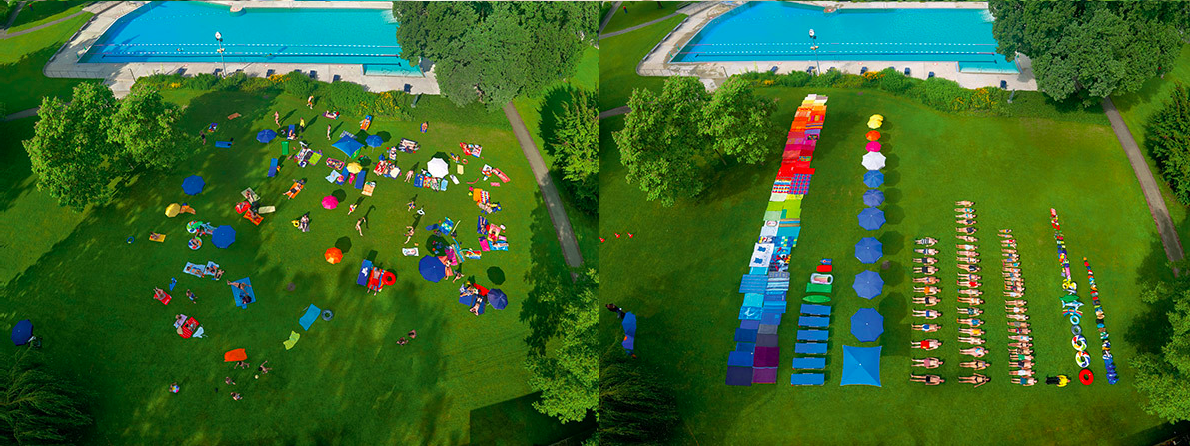

**Hello and welcome to my very first kernel! **

This is still a work in progress, feel free to make suggestions or ask questions.
If there is sufficient interest I could also translate the explanations in French. Tell me in the comments (and in the form of upvotes if you are so inclined haha :) )

As of Nov 22nd I have focused on the learning platforms favored to learn data science, and how it breaks down by country.

If I have time in the coming days I might then explore the free text responses. Natural language processing, yay!

I kept in this kernel a few of the "wrong turns" I made while analyzing the data, so you can see the approach and not only the finished result. It may seem obvious to the grizzled veterans, but I hope it will be useful to other beginners like me.

Image credits: Wonderful Ursus Wehrli https://www.kunstaufraeumen.ch/en

In [1]:
#This is the default setup of the environment

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

#dataviz
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
sns.set_style('whitegrid')

I  start by focusing on the learning platforms respondents found most useful. (Columns "LearningPlatformUsefulness....", let's them call LP for short.) 

I started there because we have 18 uniform features to look at, each with relatively contained number of categories: 4 (empty, Very, Somewhat or Not useful). And since I am myself learning data science, I will probably learn something useful too :)

In [2]:
#Note I added the "encoding='latin-1' argument to properly download the document, the formatting was causing problems
choices = pd.read_csv('../input/multipleChoiceResponses.csv', encoding='latin-1')
choices.head(5)

In [3]:
#Since we will be working with these columns quite a bit I start by listing them all in a list
#It will prove useful to also create a list of the values used for the 3 possible answers
#Then I rename each column name in a shorter, more manageable format
#I create a dataframe called LP (=LearningPlatforms) to work on these specific columns

platforms = ['LearningPlatformUsefulnessArxiv',
                         'LearningPlatformUsefulnessBlogs',
                         'LearningPlatformUsefulnessCollege',
                         'LearningPlatformUsefulnessCompany',
                         'LearningPlatformUsefulnessConferences',
                         'LearningPlatformUsefulnessFriends',
                         'LearningPlatformUsefulnessKaggle',
                         'LearningPlatformUsefulnessNewsletters',
                         'LearningPlatformUsefulnessCommunities',
                         'LearningPlatformUsefulnessDocumentation',
                         'LearningPlatformUsefulnessCourses',
                         'LearningPlatformUsefulnessProjects',
                         'LearningPlatformUsefulnessPodcasts',
                         'LearningPlatformUsefulnessSO',
                         'LearningPlatformUsefulnessTextbook',
                         'LearningPlatformUsefulnessTradeBook',
                         'LearningPlatformUsefulnessTutoring',
                         'LearningPlatformUsefulnessYouTube']

LPlist = ['Arxiv',
          'Blogs',
          'College',
          'Company',
          'Conferences',
          'Friends',
          'Kaggle',
          'Newsletters',
          'Communities',
          'Documentation',
          'Courses',
          'Projects',
          'Podcasts',
          'SO',
          'Textbook',
          'TradeBook',
          'Tutoring',
          'YouTube']

useful_cols = ['Very useful', 
               'Somewhat useful', 
               'Not Useful']

LP = choices[platforms]
LP.columns = LPlist
LP.describe(include=['O'])

From the 'count' in the previous table describing our LP dataframe, we see the numbers don't match the size of the dataframe. There are many missing values. This is fine. But let's see how many respondents actually didn't respond to *any* of these 18 questions on which LearningPlatforms they found useful or not.

In [4]:
print(len(LP)-len(LP.dropna(how='all')), 'respondents didn\'t answer any of the LearningPlatform question','\n',
      'They represent', str(round(100*(len(LP)-len(LP.dropna(how='all')))/len(LP),2)),'% of respondents')

Then I wanted to double check if the 18 columns "LearningPlatformUsefulness..." were actually listing ratings for *all* platforms used by the respondent, as selected in the question 'LearningPlatformSelect'.
As it turns out below, 693 respondents didn't rate *all* the platforms they used and left some unrated. 
In a later version we may use this information to see if there is a pattern. I'll skip for now.

In [5]:
#I wanted to check if the respondents had been constrained in their answers 
#so that they would answer exactly each question on usefulness for the learning 
#platform they had previously selected at the question: LearningPlatformSelect :  
#What platforms & resources have you used to continue learning data science skills? (Select all that apply)

LPcheck = LP.copy()
LPcheck['LearningPlatformSelect'] = choices['LearningPlatformSelect'].apply(
    lambda i : str(i).split(',') if pd.notnull(i) else [])

LPcheck['NumberLP selected'] = LPcheck['LearningPlatformSelect'].apply(lambda x: len(x))
LPcheck['LPrated'] = LPcheck[LPlist].count(axis=1)
LPcheck['Missing'] = (LPcheck['NumberLP selected'] - LPcheck['LPrated']).replace({0:np.nan})

#LPcheck = LPcheck.loc[LPcheck['LPrated'] < LPcheck['NumberLP selected']]


print('Among respondents about the Learning Platforms,', LPcheck['Missing'].count(),
      'did not rate the usefulness of at least one platform they had selected',
      'leaving each on average', round(LPcheck['Missing'].sum()/LPcheck['Missing'].count(),2),
      'platforms used but not rated')



Click the "code" buttons to expand the hidden code snippets and see my initial approach to analyze the LP dataframe, step-by-step.
As you will see it is instructive but it is flawed until I plot the first correlation matrix and cluster map. Can you spot why? Scroll below for a corrected more rigorous approach.

In [6]:
#Here we start by replacing categorical answers with 0s and 1s
#It will allow us to explore our data with visual tools like simple correlations between Platforms
#We arbitrarily choose to model answers crudely by either "positive" or "negative or missing"
#It will help quickly visualizing the most useful platforms in aggregate form

LP2 = LP.replace({'Very useful': 1,
             'Somewhat useful': 1,
             'Not Useful': 0,
             np.nan : 0
            })

#We create a Series to store total useful ratings counts by Learning Platforms (=tools)
#It will enable us to have a list of paltforms sorted by overall usefulness
sums = LP2.sum()
sums.sort_values(ascending=False, inplace=True)

#We  re-index our LP2 dataframe so the rows are sorted by the platforms most often rated as useful.
#This is mostly cosmetic, it won't have any incidence on the results
LP2 = LP2.reindex(columns= sums.index)

#Let's plot the correlations between each Learning platform being rated as useful

#We create the dataframe containing the correlation coefficients
cLP2 = LP2.corr()

#Typical masking of upper triangle
maskLP2 = np.zeros_like(cLP2, dtype=np.bool)
maskLP2[np.triu_indices_from(maskLP2)] = True

#plotting of the graph
plt.figure(figsize=(12, 12))
sns.heatmap(cLP2, mask = maskLP2, annot=True)
sns.clustermap(cLP2)
plt.show()    

We can see that some light correlation especially among the most used ones: some Learning Platforms seem rated as useful more often together. For the top 5, we see correlation coefficients above 0.3, which isn't great but might warrant more investigation... but hold on. This is when I realized **this approach was flawed!**

I wanted correlations computed between our 0s and 1s: Either respondents were finding the platform useful (mabe even very Useful) or they were finding it Not useful, including not even bothering answering the question, most likely because they hadn't used said platform that much. 
But I had been using LP2, which included rows where respondents hadn't rated any platform. In other words, the many respondents who simply skipped these questions were creating noise and skewing the meaning of the correlations.

Check out below the difference when I start from our variable LP3, where we dropped rows where all answers are missing:

In [7]:
#Here I was curious if dropping the many rows where we had NaNs for *all* LP questions 
#(5611 rows dropped) would affect the correlations

LP3 = LP.dropna(how='all')
#for simplicity I wrote functions to simplify the steps above

#cleanLP replaces Usefulness categories with 0s and 1s and orders the Df by most useful
def cleanLP(df) :
    dfi = df.replace({'Very useful': 1,
             'Somewhat useful': 1,
             'Not Useful': 0,
             np.nan : 0
            })
    sums_i = dfi.sum()
    sums_i.sort_values(ascending=False, inplace = True)
    return dfi.reindex(columns= sums_i.index)
    
#corr_plot sets up plotting from a correlation matrix
def corr_plot(df, plot):    
    if plot == 'corr' :
        mask_i = np.zeros_like(df, dtype=np.bool)
        mask_i[np.triu_indices_from(mask_i)] = True
        plt.figure(figsize=(12, 12))
        sns.heatmap(df, mask = mask_i, annot=True)
    elif plot == 'cluster' :
        sns.clustermap(df)
    plt.show()

In [8]:
#Let's visualize correlations for LP2, 
#LP2 is our Dataframe version of LP with rows dropped where all responses are missing
corr_plot(cleanLP(LP3).corr(), 'corr')
corr_plot(cleanLP(LP3).corr(), 'cluster')

As expected, the coefficients fell to meaningless levels. After this wrong turn, we simply observed that by taking into account the 0's due to respondents skipping questions, we gave 1's who were present an undue weight, and they artificially boosted correlations between the most rated platforms in general. Oh well!



In [9]:
#For later use:
#we store in LP4 the 'clean' version of LP with All-NaN rows dropped (LP3) and categories replaced by 0/1
LP4 = LP3.replace({'Very useful': 1,
             'Somewhat useful': 1,
             'Not Useful': 0,
             np.nan : 0
            })

#and sums5 for the ordered list of most-used platforms
TopLPlist = LP4.sum().sort_values(ascending=False).index
LP4 = LP4.reindex(columns= TopLPlist)


Now I wanted to see if Age or Tenure was a factor in which platforms respondents found useful. To make things faster I simply print out the maximum of correlation coefficients between Age or Tenure and the positive rating of each LP.


In [10]:
#We create a variable df LP5 by concatenating Age to our LP3 (with All NaN rows already dropped)
#We drop the rows with any Age missing
#We make sure to concat a .loc of the Age Series from choices with an index identical to LP3
#this avoids adding new NaN rows by mistake to the LPlist columns

LP5 = pd.concat([LP3, choices.loc[LP3.index,'Age']], axis=1, copy = True).dropna(how='any', subset=['Age'])
print('Max correl. coeff. between rating LP useful and Age:', round(abs(cleanLP(LP5).corr().loc['Age',LPlist]).max(),3))

In [11]:
def Tenure_to_num(df):
    
    df = df.replace({'1 to 2 years': 2,
               '3 to 5 years': 4.5,
               'Less than a year': 0.5,
               'More than 10 years': 20,
               '6 to 10 years': 8,
               'I don\'t write code to analyze data': 0})
    return df

In [12]:
LP5_T = pd.concat([LP3, Tenure_to_num(choices.loc[LP3.index,'Tenure'])],
                  axis=1, copy = True)#.dropna(how='any', subset=['Tenure'])
LP5_T.columns
print('Max correl. coeff. between rating LP useful and Tenure:', round(abs(cleanLP(LP5_T).corr().loc['Tenure',LPlist]).max(),3))

In [13]:
def Gender_to_num(df):
    df = df.replace({'Male': 0,
                     'Female': 1,
                     'A different identity': np.nan,
                     'Non-binary, genderqueer, or gender non-conforming': np.nan})
    return df


LP5_G = pd.concat([LP3, Gender_to_num(choices.loc[LP3.index,'GenderSelect'])],
                  axis=1, copy = True).dropna(how='any', subset=['GenderSelect'])
LP5_G.columns
print('Max correl. coeff. between rating LP useful and Gender:', round(abs(cleanLP(LP5_G).corr().loc['GenderSelect',LPlist]).max(),3))

There doesn't seem to be a strong correlation between Age nor Tenure or Gender, and  Usefulness reported for any platform. 

The maximum coefficient is only 0.129 in absolute. (Make sure to always consider negative coefficient, not only the positive ones). Same thing with Tenure, only a 0.176, and Gender 0.112.

In [14]:
#By the way, I noticed below not everyone seems to answer all questions truthfully. 
#Fortunately, they don't seem to be that many (37 according to my arbitrary criteria)
#and they invent a very young age roughly as often as very old. 
#This should not be statiscally significant for correlations.

jokers37 = choices.copy().dropna(subset=['Age'], how='any').loc[((choices['Age']<11)|(choices['Age']>85)),'Age'].astype(int)
print('Never trust responses to a survey before checking extremes first')
plt.Figure(figsize=(16,12))
sns.countplot(jokers37)
plt.show()


Now I will be looking at the aggregate ratings by Learning Platform, with three scores:
1. **Overall useful **Do people use them at all, and find them at least somewhat useful at all?  
2. **Rate useful **Do people who *are* using it find it *Very* useful more than simply *somewhat* useful?
3. **Neg vs pos** Do people rating the platform find it more often *Not* useful?

I will plot the aggregate scores for the entire population then dive down for each country to identify outliers and trends.


In [15]:
Aggr_LP = pd.DataFrame(0,index = TopLPlist, columns = useful_cols).astype(int)
for i in Aggr_LP.index :
    for j in useful_cols :
        Aggr_LP.loc[i, j] = LP3[i].value_counts()[j]

Aggr_LP['Overall useful'] = 100*Aggr_LP[useful_cols[:2]].sum(axis=1) / len(choices)
Aggr_LP['Rate useful'] = 100*Aggr_LP['Very useful'] / Aggr_LP[useful_cols[:2]].sum(axis=1)
Aggr_LP['Neg vs pos'] = 100*Aggr_LP['Not Useful'] / Aggr_LP[useful_cols].sum(axis=1)

round(Aggr_LP,2)

In [16]:
plt.figure(figsize=(16,12))
ax1 = plt.scatter(x=Aggr_LP['Neg vs pos'], 
                  y=Aggr_LP['Rate useful'],
                  s=Aggr_LP['Overall useful']*30)
ax1.axes.set_xlabel('Negative sentiment(in %)',size=16)
ax1.axes.set_ylabel('Rate of real usefulness (in %)',size=16)

plt.xlim(xmin=0)
plt.ylim(ymin=0)
for i in TopLPlist :
    plt.annotate(i,(Aggr_LP.loc[i,'Neg vs pos']+0.2, 
                    Aggr_LP.loc[i,'Rate useful']+1),size=12)

Above, a successful Learning platform would be large dots in the top left (Yay, Kaggle! Stack Overflow, Projects and Courses are popular too!) and avoid being small points the bottom right (oh no, Podcasts...)
As we can see:
1. Overall satisfaction/usage with the platforms ranges from around 40% to less than 2%.
2. Most used platforms seem to also be the most appreciated as useful, and are found "not useful" least often (The large dots aggregate to the top left).
3. It will be interesting to plot dots for specific countries over this one to explore difference in perceptions. See below:

Now let's slice by country. As introductory cleanup, I mixed the missing responses for "Country" into "Other". 

Also, isn't Taiwan the same answer as the Republic of China?

We have 18 LPs and 52 countries (including "Other"). Since several ratings (scores for one LP and one country) only involve a handful of respondents, I first set up a "Top countries" list to quickly perform tests on a smaller number of countries and dive into dataframes of more manageable sizes. From the pareto that we see below, we still need to include 23 countries to reach 80% of our ratings, so we cannot simply discard the ratings from smaller countries and need to take them into account.

In [17]:
choices['Country'].replace({np.nan : 'Other'},inplace=True)
LP6 = pd.concat([LP3, choices.loc[LP3.index,'Country']], axis=1, copy=True)
top_countries = LP6['Country'].value_counts().drop('Other')
all_countries = LP6['Country'].value_counts()
pareto = 0
i=0
while pareto < 0.8 :
    pareto = pareto + top_countries[i]/len(LP6)
    i = i+1

top_countries = top_countries[:i]    
print('With ', i, 'countries we cover ', 100*round(pareto, 3), '% of the population rating LPs')

In [18]:
def LP_crit(**crits) :
    
    df = pd.DataFrame(index = TopLPlist, columns = useful_cols)

    slices = True
    slices_pop = True
    LP_c = LP3.copy()
    for key in crits.keys():
        LP_c[key] = choices[key]
        slices = slices & (LP_c[key]==crits[key])
        slices_pop = slices_pop & (choices[key]==crits[key])
        df[key] = crits[key] 
    LP_c = LP_c.loc[slices]
    
    
    for i in TopLPlist :
        for j in LP_c[i].value_counts().index :
            df.loc[i,j] = LP_c[i].value_counts()[j]

        #here we loop through value_counts of base dataframe instead of looping through 
        #our overarching LPlist5 list of platforms to avoid raising key errors if a country
        #has not rated a certain platform at all.
        
    df['Slice pop'] = len(choices.loc[slices_pop])
    df['Slice pop LP resp'] = len(LP_c)
    
    df['Overall useful'] = 100*df[useful_cols[:2]].sum(axis=1) / df['Slice pop']
    df['Rate useful'] = 100*df['Very useful'] / df[useful_cols[:2]].sum(axis=1)
    df['Neg vs pos'] = 100*df['Not Useful'] / df[useful_cols].sum(axis=1)
    
    
    df = df.replace({np.nan:0})
    df = df.rename_axis('LP')
    df.reset_index(inplace=True)
    return round(df,3)


In [37]:
def plot_LP(df):
    plt.figure(figsize=(16,12))
    ax2 = plt.scatter(x=Aggr_LP['Neg vs pos'],
                  y=Aggr_LP['Rate useful'],
                  s=Aggr_LP['Overall useful']*30,
                  c='0.5')

    ax2.axes.set_xlabel('Negative sentiment(in %)',size=16)
    ax2.axes.set_ylabel('Rate of real usefulness (in %)',size=16)

    plt.scatter(x=df['Neg vs pos'],
            y=df['Rate useful'],
            s=df['Overall useful']*30,
            c='r'
           )

    for i in TopLPlist:
        xi = df.loc[df['LP'] == i,'Neg vs pos']
        yi = df.loc[df['LP'] == i,'Rate useful']
        xm = Aggr_LP.loc[i,'Neg vs pos']
        ym = Aggr_LP.loc[i,'Rate useful']
    
        offset = (xi-xm)/abs(xi-xm)

        plt.annotate('',
                xy=(xi,yi),
                xycoords='data',
                xytext=(xm,ym),
                textcoords='data',
                arrowprops=dict(arrowstyle="->",
                                shrinkA=0,
                                shrinkB=0,)
                )    

        if offset.item() <= 0:
            plt.annotate(i+'!!',
                         (xi,
                          yi), rotation =25,
                         size=13,
                         color = 'g')
        else:
            plt.annotate(i[:min(4,len(i)+1)]+'...',
                         (xi,yi),
                         size=11, rotation = -10,
                         color = '#5b3f21')

    plt.show()    

plot_LP(LP_crit(Country='France'))



We can see above French Kagglers (in red) are less critical of most platorms, and often find them even more useful. 6 even have 0 in Negative sentiment.

Exceptions include Stack Overflow, Newsletters, Communities and Youtube, where they show more insatisfaction than average (in grey).
Projects, Courses and Kaggle are found Very useful even more often than by the average Kaggler!


Now let's concatenate in LPC the aggregate ratings for each individual country. This will allow to  look for trends and outliers in bulk.


In [20]:
LPC = pd.DataFrame({})
for i in all_countries.index :
    LPC = pd.concat([LPC,LP_crit(Country=i)], axis=0)
LPC.reset_index(inplace=True, drop=True)

This LPC dataframe is 936 rows long. 18 LPs x 52 countries times. The interesting part is to see which ratings deviate from the norm. Since we consider 3 scores for each rating, we have a total of 2808 scores to compare.

I started by surfacing scores that were outliers by defining it as being outside 2x Std of the weighted Mean of any of our 3 scores.

1. Mean scores are the aggregate scores for the entire survey
2. Weights are the population of respondents of each country who had answered LP questions

Out of 2808 scores, we see 342 outliers turn up. 
I marked with a two-letter attribute: 

1. First letter for the score outside the norm (O for Overall, R for Rate, N for Neg scores)
2. Second letter for sentiment (P for more Positive than the norm, N for more Negative)

Many of these outliers scores are due to only a handful (mostly small countries rating the less used LPs). So we need to also filter by size of samples.
First I filtered by only looking at the top countries by number of ratings. But we lose valuable information from the rest of the population simply because they live in separate countries where they might as well practice similar data science... 
Then I decided to filter so outliers would be marked as such if the population of the country answering the LP questions was above an arbitrary threshold (say 1% of the population answering that part of the survey). They were down to a more manageable number of 37. They are listed below, sorted by country then sorted by LP.

As you can see, several are still due to only a handful of ratings for a platform.

In [21]:
for i in TopLPlist:
    LPC.loc[LPC['LP']==i,'Wmean Overall']  = Aggr_LP.loc[i,'Overall useful']
    LPC.loc[LPC['LP']==i,'Wmean Rate'] = Aggr_LP.loc[i,'Rate useful']
    LPC.loc[LPC['LP']==i,'Wmean Neg'] = Aggr_LP.loc[i,'Neg vs pos']
    

LPC['Dist Overall'] = (LPC['Overall useful'] - LPC['Wmean Overall'])**2 * LPC['Slice pop']/(len(choices)-1)
LPC['Dist Rate'] = (LPC['Rate useful'] - LPC['Wmean Rate'])**2 * LPC['Slice pop LP resp']/(len(LP6)-1)
LPC['Dist Neg'] = (LPC['Neg vs pos'] - LPC['Wmean Neg'])**2 * LPC['Slice pop LP resp']/(len(LP6)-1)


for i in TopLPlist:
    LPC.loc[LPC['LP']==i,'Std Overall'] = np.sqrt(LPC.loc[LPC['LP']==i,'Dist Overall'].sum())
    LPC.loc[LPC['LP']==i,'Std Rate'] = np.sqrt(LPC.loc[LPC['LP']==i,'Dist Rate'].sum())
    LPC.loc[LPC['LP']==i,'Std Neg'] = np.sqrt(LPC.loc[LPC['LP']==i,'Dist Neg'].sum())


#Series/slices of Booleans to slice LPC and filter out outliers
OP = ((LPC['Overall useful'] - LPC['Wmean Overall']) > 2*LPC['Std Overall']).rename('OP')
RP = ((LPC['Rate useful'] - LPC['Wmean Rate']) > 2*LPC['Std Rate'])
NP = ((LPC['Neg vs pos'] - LPC['Wmean Neg']) < -2*LPC['Std Neg'])
ON = ((LPC['Overall useful'] - LPC['Wmean Overall']) < -2*LPC['Std Overall'])
RN = ((LPC['Rate useful'] - LPC['Wmean Rate']) < -2*LPC['Std Rate'])
NN = ((LPC['Neg vs pos'] - LPC['Wmean Neg']) > 2*LPC['Std Neg'])
Size = (LPC['Slice pop LP resp'] > (len(LP6)/100))

LPC['Outliers'] = OP.apply(lambda x: x*'OP') \
+ RP.apply(lambda x: x*'RP') \
+ NP.apply(lambda x: x*'NP') \
+ ON.apply(lambda x: x*'ON') \
+ RN.apply(lambda x: x*'RN') \
+ NN.apply(lambda x: x*'NN') \

LPC['OP'] = OP.apply(lambda x: x*'OP')
LPC['RP'] = RP.apply(lambda x: x*'RP')
LPC['NP'] = NP.apply(lambda x: x*'NP')
LPC['ON'] = ON.apply(lambda x: x*'ON')
LPC['RN'] = RN.apply(lambda x: x*'RN')
LPC['NN'] = NN.apply(lambda x: x*'NN')    

In [22]:
Outliers = LPC.loc[(OP | RP | NP | ON | RN | NN )
                   & Size] 
Outliers.set_index(['Country','LP','Outliers'])
Outliers.sort_values(['Wmean Overall','Slice pop'], ascending=False)\
.set_index(['Country','LP','Outliers']).loc[:,:'Wmean Neg'].round(3)

In [23]:
Outliers.sort_values(['Wmean Overall','Slice pop'], ascending=False).set_index(['LP','Country','Outliers']).loc[:,:'Wmean Neg'].round(3)

Then I wanted to visualize the trends and see the dispersion for our 18x3 scores. I decided to plot boxplots for the 3 scores for each platform, stacked so we can compare them at a glance. 

Below, I perform a rather inelegant hack in order to display a triple column with the "Hue" argument of boxplots, even if we look at three different scores, not the effect on a same unique score of a 3-value variable. To do that:
1. I create three copies of our dataframe LPC, with an additional column called Hue. 
2. Each copy gets a different categorical marker in its column "Hue".
3. The first copy's columns are kept identical to the original's
4. Then I copy over into the columns for the score "Overall useful" of each the  other two copies, each of the original columns for the scores "Rate useful" and "Neg vs pos". 
5. Finally we concatenate the three back-to-back to read the one column "Overall useful" as three different scores on a unique graph.

In [24]:
LPC1 = LPC.copy()
LPC1['Hue'] = '% who feel as overall useful'
LPC2 = LPC1.copy()
LPC2['Hue'] = '% of real usefuleness'
LPC3 = LPC1.copy()
LPC3['Hue'] = '% of Negative sentiment'

LPC2['Overall useful'] = LPC1['Rate useful']
LPC3['Overall useful'] = LPC1['Neg vs pos']

LPCX = pd.concat([LPC1,LPC2, LPC3], axis=0)
LPCX['Overall useful'] = 100*LPCX['Overall useful']

In [25]:
plt.figure(figsize=(16,16))
bx = sns.boxplot(data=LPCX,
                 y='LP',
                 x='Overall useful',
                 hue='Hue',
                 orient='h',
                 linewidth =1,
                 fliersize=1)
plt.show()

As you can see I like my graphs packed with information. Above we can see all three scores of all platforms. In one glance we see:
1. The order of overall usefulness, steadily decreasing from over 40% (Kaggle) to around 2% (Trade books).
2. The "Real usefulness" is on average more constant around 50% for most platforms. Kaggle, Courses, SO and Projects stand out, well over 60%. Youtube slightly disappoints given how overall useful it is rated, while Arxiv and Tutoring are well received by those who use them. The score varies  wildly though, with several outliers at 0 and 1, and large quartiles.
3. The negative scores aren't distributed similarly to the overall usefulness, and keep below 5% except notable examples like podcasts and conferences.They also show many outliers.

Now let's see if we can remove the noise of the outliers due to very small samples. Note that outliers displayed on boxplots here (=fliers) are not exactly the sames as the ones I defined in our LPC dataframe above. These stand out because they are beyond 1.5 times the interquartile range outside the median range. 
This graph helps a bit but shows a lot of noise. I wanted to clean up the data more by aggregating the ratings of the smaller samples into a larger "Other" to show less dispersion that would be due only to ratings by people for a same country.

First for more lisibility, each scores shown separately and ordered:

In [26]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

In [27]:
plt.figure(figsize=(16,12))
sns.boxplot(data=LPC.sort_values('Wmean Overall',ascending=False),
            y='LP',
            x='Overall useful',
            linewidth =1,
            fliersize=1)    
plt.figure(figsize=(16,12))
sns.boxplot(data=LPC.sort_values('Wmean Rate',ascending=False),
            y='LP',
            x='Rate useful',
            linewidth =1,
            fliersize=1) 
plt.figure(figsize=(16,12))
sns.boxplot(data=LPC.sort_values('Wmean Neg',ascending=False),
            y='LP',
            x='Neg vs pos',
            linewidth =1,
            fliersize=1) 
plt.show()    

Now we want to get rid of outliers from the smaller samples, to see only dispersion and outliers from countries/ratings of significant size. We proceed by aggregating the ratings for each LP rated by fewer than 15 people in a given country into the "Other" rating of that LP. 

We make sure to update the ratings of that LP in the country "Other", but also the columns "Country pop" and "Country pop LP resp" corresponding to the number of people in the country and rating LPs, so the scores are computed in a coherent manner. The updated plots look a bit better, with less dispersion and fewer outliers, especially for the "Rate Useful" score.

In [28]:
LPCZ = LPC.copy()

for i in TopLPlist:
    slice_i = (LPCZ[useful_cols].sum(axis=1)<15) & (LPCZ['Country'] != 'Other') & (LPCZ['LP']==i)
    slice_j = (LPCZ['Country'] == 'Other') & (LPCZ['LP']==i)
    if len(LPCZ.loc[slice_i]) > 0:
        LPCZ.loc[slice_j, useful_cols + ['Slice pop', 'Slice pop LP resp']] = \
        LPCZ.loc[slice_j, useful_cols + ['Slice pop', 'Slice pop LP resp']] + \
        LPCZ.loc[slice_i, useful_cols + ['Slice pop', 'Slice pop LP resp']].sum(axis=0)
        
        LPCZ.drop(labels=LPCZ.loc[slice_i].index,inplace=True)
    
LPCZ['Overall useful'] = LPCZ[useful_cols[:2]].sum(axis=1) / LPCZ['Slice pop']
LPCZ['Rate useful'] = LPCZ['Very useful'] / LPCZ[useful_cols[:2]].sum(axis=1)
LPCZ['Neg vs pos'] = LPCZ['Not Useful'] / LPCZ[useful_cols].sum(axis=1)

In [29]:
LPCZ1 = LPCZ.copy()
LPCZ1['Hue'] = '% who feel as overall useful'
LPCZ2 = LPCZ.copy()
LPCZ2['Hue'] = '% of real usefuleness'
LPCZ3 = LPCZ.copy()
LPCZ3['Hue'] = '% of Negative sentiment'

LPCZ2['Overall useful'] = LPCZ1['Rate useful']
LPCZ3['Overall useful'] = LPCZ1['Neg vs pos']

LPCZX = pd.concat([LPCZ1,LPCZ2, LPCZ3], axis=0)
LPCZX['Overall useful'] = 100*LPCZX['Overall useful']

plt.figure(figsize=(16,16))

sns.boxplot(data=LPCZX,
            y='LP',
            x='Overall useful',
            hue='Hue',
            orient='h',
            showmeans=True,
            linewidth =1,
            fliersize=1)

plt.show()    

In [30]:
plt.figure(figsize=(16,12))
ax = sns.boxplot(data=LPCZ.sort_values('Wmean Overall',ascending=False),
                 y='LP',
                 x='Overall useful',
                 linewidth =1,
                 fliersize=1) 

plt.figure(figsize=(16,12))
sns.boxplot(data=LPCZ.sort_values('Wmean Rate',ascending=False),
            y='LP',
            x='Rate useful',
            linewidth =1,
            fliersize=1
           ) 

plt.figure(figsize=(16,12))
sns.boxplot(data=LPCZ.sort_values('Wmean Neg',ascending=False),
            y='LP',
            x='Neg vs pos',
            linewidth =1,
            fliersize=1
           ) 
plt.show()       

It worked! Look especially how our score "Overall useful" is less noisy. 

I am looking into how to annotate fliers on boxplots, so we could show there which countries yield scores so different from the norm, for each LP. It seems to involve the Lines attributes output by plt.boxplot as a dict. I will report here when I find how to annotate the graph!


Then I started looking at the Learning Categories (called LC for short). The questions seem to be similar: Where did Kagglers learn Data Science first? And on which LCs are they now spending most of their time continuing to learn Data Science?

In [31]:
FirstTraining = choices['FirstTrainingSelect'].value_counts()


LearnCat = choices[['LearningCategorySelftTaught',
                    'LearningCategoryOnlineCourses',
                    'LearningCategoryWork',
                    'LearningCategoryUniversity',
                    'LearningCategoryKaggle',
                    'LearningCategoryOther']]
LCList = ['Self-taught',
          'Online Courses',
          'Work',
          'University',
          'Kaggle',
          'Other']

LearnCat.columns = LCList

LC1 = LearnCat.dropna(how='all')

#LCcheck = LC1.sum(axis=1).value_counts(dropna=False).sort_index()
#LCcheck : All totals are indeed equal to 100.


print(len(LearnCat)-len(LC1),
      'respondents didn\'t answer any of the current LearningCategory question','\n',
      'They represent', str(round(100*(len(LearnCat)-len(LC1))/len(LearnCat),2)),'% of total survey','\n',
      'The ', len(LC1), 'respondents who answered use an average of',
      str(round(LC1[LC1!=0].count(axis=1).mean())), 'platforms for their continued learning','\n',
      len(LC1[LC1==100].dropna(how='all')), 'use only one tool for 100% of their learning')

#Joker1337 = LC1[LC1==0.1337].dropna(how='all').index.tolist()
#Joker1337 is the index of a respondentspeaking 1337-speak. 37-y old from Australia.
#Funny how 37 keeps popping up in jokes inthis survey :)

In [32]:
LC1 = LC1.replace({np.nan:0})

LCDist = LC1.sum()

LC2 = pd.concat([LC1,choices.loc[LC1.index,'FirstTrainingSelect']],axis=1)
LC2 = LC2.replace({'Online courses (coursera, udemy, edx, etc.)':'Online Courses',
                   'University courses' : 'University',
                   'Kaggle competitions' : 'Kaggle'})

#Is it critical to drop NaNs from "First Learning" after concat here??



#HERE I WOULD LIKE TO ORDER THE SLICE SO CATEGORIES GET THE SAME COLORS
#fig, axs = plt.subplots(1,2, figsize=(16,6))

#pie1 = FirstTraining.plot.pie(ax=axs[1])
#pie1.set_title('Platforms where we first started learning', size=15)
#pie2 = LC1.sum().plot.pie(ax=axs[0])
#pie2.set_title('Platforms where we currently learn', size=15)

#plt.show()    

In [33]:


LC_allratings = pd.Series(pd.concat([LC2[i] for i in LCList], axis=0))
LC_all1stTrain = pd.Series(pd.concat([LC2['FirstTrainingSelect'] for i in LCList], axis=0))

LC_each = pd.DataFrame({'Ratings': LC_allratings,
                        'Learning Cat': pd.concat([pd.Series(len(LC1)*[LC1.columns[i]], index=LC1.index) for i in range(len(LC1.columns))],axis=0),
                        'First Training' : LC_all1stTrain})

LC_each['Bins']=pd.cut(LC_each['Ratings'],np.arange(-10,110,10))
plt.subplots(figsize=(16,8))
plt.xlim(xmin=100)

axlc = sns.countplot(x= 'Bins',
                     hue='Learning Cat',
                     data=LC_each)
axlc.set_title('What percentage of your current machine learning / data science training falls under each category')
axlc.set_xlabel('intervals of % of current training')
axlc.set_ylabel('number of respondents')
plt.show()  

Above we see that most respondents used smaller percentages to rate which platforms they used to learn. Self-taught is by far the category where respondents learn the most (It is the LC least rated at 0%).
Self-taught is also the LC most represented even as the percentage of that Learning Category grows compared to others in the total: People who owe above 50%, or even 90% of their current learning to one platform owe it in majority to "Self-Taught".

In [34]:
plt.subplots(figsize=(16,12))

bxlc = sns.violinplot(y = 'Ratings', 
                      x = 'Learning Cat', 
                      data = LC_each,
                      cut=0,
                      scale='count',
                     inner='box')
bxlc.set_xlabel('Platform currently used for learning by a certain % of total learning')
bxlc.set_ylabel('% of total learning respondents spend on each platform')

plt.show()    

We see above the percentage of where respondents say they are currently learning, attributed to each LC. 
By seeing how the first two violins keep wide up until 100%, we understand that "Self-Taught" and to a lesser degree "Online courses" are the LC where some respondents perform more their learning almsot exclusively : some people rated these LC above  80% of where they learned data science. 

Self-taught is the only with a narrower base (0%) than "body" (20-60%) which means that a wide majority of respondents attribute at least some of their current learning to being Self-Taught. 

To the contrary, the wide base of "University" for example, despite thin and keeping fairly uniform up until 100%, has a wide base at 0%: There are respondents attributing shares of their current learning to University at all levels. A majority at 0%, then only very slightly decreasing from 10 t 100%.

See the wiggly bumps, especially clear for "Work" and "Kaggle"? They illustrate that most people responded to this questions with round percentages (10%, 20%, 30%, 40%, 50%), rather than in-between.

In [35]:
order = ['Self-taught',
         'Online Courses',
         'Work',
         'University',
         'Kaggle',
         'Other']

plt.subplots(figsize=(12,16))

cxlc = sns.violinplot(x = 'Ratings', 
                      y = 'First Training', 
                      hue = 'Learning Cat',
                      hue_order = order,
                      order = order,
                      linewidth=1,
                      data = LC_each,
                      cut=0,
                      scale='count',
                     inner='box')
cxlc.set_title('By First Training platform, where do Data scientists *currently* learn',size=15)

plt.show()    

**Where respondents first started to learn data science has a notable impact on where they keep learning the most.**

As we can see above, based on which LC was the platform where respondents first learned Data Science, they often spend there an outsized share of their current learning, compared to respondents who learned on other Learning Categories:

See the first group of violins at the top, for Self-Taught:
People who started by learning on their own are still overwhelmingly learning that way: The media at 50% for "Self taught" the blue violin, shows that half of them spend at least 50% of their learning as "Self-taught". 
They also almost never answer that they don't learn that way anymore (violin almost nil at 0%) and show a significant portion answering they learn *only* that way (wide at 100%).

Look at the second group, and how the yellow violin for "Online courses" if by far the widest and most to the right of all yellow violins in other groups. People who started with "Online courses" still learn significantly on that Learning Category. The median is at 50%: half of them even attribute to online courses at least half of what they currently learn. A decent proportion are still elarning 100% from Online courses.

For Work, the third group:
People who started at work still attribute in majority at least 40% of their current learning to Work. Being Self-Taught seems to be a close second, especially when atributing to it around 20% of current learning.

Look at University, in the fourth group:
People who started in University still attribute to it a very significant portion of their current learning to it. A majority gives it 40% or more. Fewer are those who attribute to being self-taught more than 20% of their current learning. 

And Kaggle, in the fifth group:
People who started on Kaggle are almost exclusively those who still learn there by 30% or more. We see people learning on Kaggle by 10% or 20% currently when they started learning elsewhere, but they don't attribute more than that. Note some Kagglers are still learning 100% of what they learn up here on Kaggle! One might say it is sufficient to become expert :)

Other, in the sixth group:
This is where people still continue learnign "some other way" in a significant manner.
